## PREPROCESSING
### Get the dataset
Load the dataset, split it in two for trainin and validation. As in the Reference model provided by [Lyft](https://level5.lyft.com/), a dataframe with one scene per row is created.

In [26]:
DATASET_VERSION = 'v1.02-train'
DATASET_ROOT = '../data/'

In [27]:
%load_ext autoreload

from datetime import datetime
from functools import partial
import glob
#Disabled for numpy and opencv: avod has opencv and numpy versions for several methods
from multiprocessing import Pool

import os
#os.environ["OMP_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import pandas as pd
import cv2
import PIL
from PIL import Image
import numpy as np
from tqdm import tqdm, tqdm_notebook
import argparse
import scipy
import scipy.ndimage
import scipy.special
from scipy.spatial.transform import Rotation as R

from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud, Box, Quaternion
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
gpus = tf.compat.v1.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=1) 
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True, gpu_options=gpu_options))

1 Physical GPUs, 1 Logical GPU
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 850M, pci bus id: 0000:0a:00.0, compute capability: 5.0
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [29]:
level5data = LyftDataset(json_path=DATASET_ROOT + "/v1.02-train", data_path=DATASET_ROOT, verbose=True)

9 category,
18 attribute,
4 visibility,
15991 instance,
8 sensor,
128 calibrated_sensor,
149072 ego_pose,
148 log,
148 scene,
18634 sample,
149072 sample_data,
539765 sample_annotation,
1 map,
Done loading in 13.6 seconds.
Reverse indexing ...
Done reverse indexing in 4.4 seconds.


## <font color="pink">TRAINING</font>
Based on the [AVOD algorithm](https://github.com/kujason/avod), we train the dataset. 
The goal is to study how the accuracy changes based on the type of sensors in input, and their number, thus changes to the AVOD algorithm have been made. Here we keep the two stage model.
Will be divided in steps, to mimick the divisions made by AVOD's authors in the code.

With respect to the original AVOD code, the following changes have been made:
<li> Upgrades for compatibity issues with tensorflow 2.0: migrated from slim libs to keras Sequential</li>
<li> Changes to support single type input </li>
<li> VGGs take as input Lyft-style dataset </li>



In [30]:
import avod
from avod.core import trainer

<b>RPN MODEL</b>: It is the fist subnetwork that makes up the double stage AVOD algorithm. It uses two VGGs, one for images, one for LiDar, to find the bottleneck.
Img VGG and Bev VGG have the same strucure, just have input from different sources. 

<b>VGG:</b> VGG is a convolutional neural network model. Here simplified model wrt K. Simonyan and A. Zisserman's model proposed in the paper "Very Deep Convolutional Networks for Large-Scale Image Recognition".
Basically, it lacks dense layers at the end, and the last group of conv layers is smaller that theirs.
Two VGGs, one for BEV, one for Images

In [31]:
import utils.anchor_helper
from utils.frame_helper import FrameCalibrationData
import utils.frame_helper
import utils.preproc_helper
import utils.bev_helper
import utils.rpn_helper

In [32]:
from PIL import Image
from avod.core import anchor_filter
from avod.core import anchor_projector
from avod.core import box_3d_encoder
from avod.core import constants
from avod.core import losses
from avod.core import model
from avod.core import summary_utils
from avod.core.anchor_generators import grid_anchor_3d_generator
from avod.datasets.kitti import kitti_aug
import avod.datasets.kitti.kitti_utils as kitti_utils
from avod.core.label_cluster_utils import LabelClusterUtils

## Test this part!!

Tests and results for the RPN model part. The following changes to the model were done after errors/issues with testing:
<li>Maybe change the use of placeholders in the future, to fit with eager execution (shorter code)</li>
<li>Some internal keras os function rises a warning, something will be depreated, doesn't tell where and what function exactly</li>

In [18]:
import avod.builders.config_builder_util as config_build
config_path = 'avod/configs/unittest_model.config'
pipe_path = 'avod/configs/unittest_pipeline.config'
model_config = config_build.get_model_config_from_file(config_path)
pipeline_config=config_build.get_configs_from_pipeline_file(pipe_path, "val")
#rpn_model = RpnModel(model_config, pipeline_config[3],
 #                        train_val_test="val",
  #                     dataset=level5data)
# array=rpn_model.feed_input(5)
#predictions = rpn_model.build()
#tensor=tf.convert_to_tensor(array)


In [ ]:
predictions = rpn_model.build()

Get a scene, show the different methods to get the boxes. Loop to get all the samples

In [106]:
# Network input data: loop to get batch info
import box_helper
import bev_helper
import frame_helper
import preproc_helper
import io
from typing import Tuple, List

classes=[]
for i in dataset.category:
    classes.append(i.get("name"))

img_input_list=[]
img_target=[]
bev_input_list=[]
ground_plane_list=[]
lidar=[]
boxes=[]
boxes_b=[]

dataset=level5data
my_scene = dataset.scene[0]

        
voxel_size = (0.4,0.4,1.5)
z_offset = -2.0
#arbitrary shape, must be square though!
bev_shape = (336,336, 3)
        
# Only handle one sample at a time for now
my_sample_token = my_scene["first_sample_token"]
my_last_sample_token = my_scene["last_sample_token"]
sample = dataset.get('sample', my_sample_token)
tok=sample['data']["CAM_FRONT"]
tok_bev=sample['data']["LIDAR_TOP"]
iboxes=dataset.get_boxes(tok)   
bboxes=dataset.get_boxes(tok_bev)
data_path, boxes, camera_intrinsic = dataset.get_sample_data(
                tok_bev)
data_path, uboxes, camera_intrinsic = dataset.get_sample_data(
                tok)

classes=[]
for i in dataset.category:
    classes.append(i.get("name"))
print(iboxes[0], boxes[0].center/4)
#anchors_info, obj_classes, label_classes, label_anchors, label_boxes_3d = preproc_helper.load_sample_info(tok, classes, dataset)

with tf.device('/GPU:0'):
    while my_sample_token!=my_last_sample_token:

        sample = dataset.get('sample', my_sample_token)
        sample_name = sample.get("token")
        img_data = dataset.get('sample_data', sample['data']["CAM_FRONT"])
        camera_token=img_data.get("token")

        tok=sample['data']["CAM_FRONT"]
        ego_pose = dataset.get("ego_pose", img_data["ego_pose_token"])
        data_path, boxes_cam, camera_intrinsic = dataset.get_sample_data(camera_token)
        data = Image.open(data_path)
        boxes.append(boxes_cam)
        #anchors_info, obj_classes, label_classes, label_anchors, label_boxes_3d = preproc_helper.load_sample_info(sample_name, classes, dataset)
        #print(label_boxes_3d.shape)
        bev_input = dataset.get('sample_data', sample['data']["LIDAR_TOP"])
        bev_data = bev_input
        bev_token= bev_input.get("token")
        lidar_data = dataset.get("sample_data", bev_token)
        lidar_filepath = dataset.get_sample_data_path(bev_token)
        ego_pose = dataset.get("ego_pose", lidar_data["ego_pose_token"])
        calibrated_sensor_lidar = dataset.get("calibrated_sensor", lidar_data["calibrated_sensor_token"])
        global_from_car = transform_matrix(ego_pose['translation'], Quaternion(ego_pose['rotation']), inverse=False)
        car_from_sensor_lidar = transform_matrix(calibrated_sensor_lidar['translation'], Quaternion(calibrated_sensor_lidar['rotation']),
                                                  inverse=False)
        lidar_pointcloud = LidarPointCloud.from_file(lidar_filepath)
        lidar_pointcloud.transform(car_from_sensor_lidar)
        lidar.append(lidar_pointcloud.points)
        x=sample["data"]["LIDAR_TOP"]
        bevboxes=dataset.get_boxes(x)
        boxes_b.append(bevboxes)
        bev = bev_helper.create_voxel_pointcloud(lidar_pointcloud.points, bev_shape, voxel_size=voxel_size, z_offset=z_offset)
        #ego_centric_map = bev_helper.get_semantic_map_around_ego(map_mask, ego_pose, voxel_size=0.4, output_shape=(336,336)) 
        bev_array = bev_helper.normalize_voxel_intensities(bev)
        bev_input_list.append(bev_array)

        file_name=dataset.get_sample_data_path(camera_token)
        image1 = Image.open(file_name)
        # compress image, it is too big
        # convert image to numpy array
        image = image1.resize((306,256), Image.ANTIALIAS)
        img_array = np.asarray(image)
        if img_input_list is not None:
            img_input_list.append(img_array)

        cam_front_token = dataset.get('sample_data', sample['data']["CAM_FRONT"])
        cam_front_data = cam_front_token.get("calibrated_sensor_token")
        cam_front_calib = dataset.get("calibrated_sensor", cam_front_data )
        cam_front_coords = cam_front_calib.get("translation")

        cam_front_left_token = dataset.get('sample_data', sample['data']["CAM_FRONT_LEFT"])
        cam_front_left_data = cam_front_left_token.get("calibrated_sensor_token")
        cam_front_left_calib = dataset.get("calibrated_sensor", cam_front_left_data )
        cam_front_left_coords = cam_front_left_calib.get("translation")

        cam_front_right_token = dataset.get('sample_data', sample['data']["CAM_FRONT_RIGHT"])
        cam_front_right_data = cam_front_right_token.get("calibrated_sensor_token")
        cam_front_right_calib = dataset.get("calibrated_sensor", cam_front_right_data )
        cam_front_right_coords = cam_front_right_calib.get("translation")

        ground_plane = frame_helper.get_ground_plane_coeff(cam_front_coords, cam_front_left_coords, cam_front_right_coords)
        ground_plane_list.append(ground_plane)
        
        token=img_data.get("calibrated_sensor_token") 
        stereo_calib_p2 = frame_helper.read_calibration(token, dataset)

        my_sample_token = dataset.get("sample", my_sample_token)["next"]



In [107]:
print(np.asarray(boxes).shape)

(125,)


In [108]:
from lyft_dataset_sdk.utils.geometry_utils import view_points
import matplotlib.patches as patches

In [109]:
img_input=np.asarray(img_input_list)
bev_input=np.asarray(bev_input_list)
#img_targetnp=np.asarray(img_target)
img_input=tf.convert_to_tensor(img_input)
print(img_input.shape)

(125, 256, 306, 3)


In [110]:
with tf.device('/CPU:0'):
    #inputs_vgg = tf.keras.layers.Input(shape=(224,224,3))
    vgg16 = tf.keras.applications.VGG16(include_top=False, input_shape=(256,306,3),weights='imagenet')
    vgg16.summary()
#    bev_data = tf.keras.applications.vgg16.preprocess_input(bev_input)
#    bev_features=vgg16.predict(bev_data)
#     #exclude fully connected
#     output = vgg16.layers[-3].output
#     #struggle with memory
    img_data = tf.keras.applications.vgg16.preprocess_input(img_input)
    img_features=vgg16.predict(img_data)
    print(img_features.shape)


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 256, 306, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 306, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 306, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 153, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 153, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 153, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 76, 128)       0     

create anchors, recalibrate camera matrix and gt boxes to fit the reshaping of the img

In [112]:
import tensorflow.keras.backend as K
w_stride=16
h_stride=16 
f_map_img_h=8
f_map_img_w=9
img_h=256
img_w=306
s_x=np.arange(0,f_map_img_w)*w_stride
s_y=np.arange(0,f_map_img_h)*h_stride
s_x, s_y=np.meshgrid(s_x,s_y)
shifts=np.vstack((s_x.ravel(), s_y.ravel(), s_x.ravel(), s_y.ravel())).transpose()



base_anchors=rpn_helper.gen_anchors(w_stride,h_stride)
print(base_anchors.shape)
base_anchors=base_anchors/4
num_feature_map=f_map_img_h*f_map_img_w
num_anchors_per_tile=6
all_anchors = (base_anchors.reshape((1, num_anchors_per_tile, 4)) + shifts.reshape((1, num_feature_map, 4)).transpose((1, 0, 2)))
border=0
total_anchors=num_feature_map*6
all_anchors = all_anchors.reshape((total_anchors, 4))
border=0
inds_inside = np.where(
        (all_anchors[:, 0] >= -border) &
        (all_anchors[:, 1] >= -border) &
        (all_anchors[:, 2] < img_w+border ) &  # width
        (all_anchors[:, 3] < img_h+border)    # height
)[0]
anchors=all_anchors[inds_inside]

c2=np.array([[221, 0, 157],[0, 221, 129],[0, 0, 1]])
x=[camera_intrinsic[0]/4, camera_intrinsic[1]/4, camera_intrinsic[2]]
x=np.asarray(x)

(6, 4)


here
(125,)


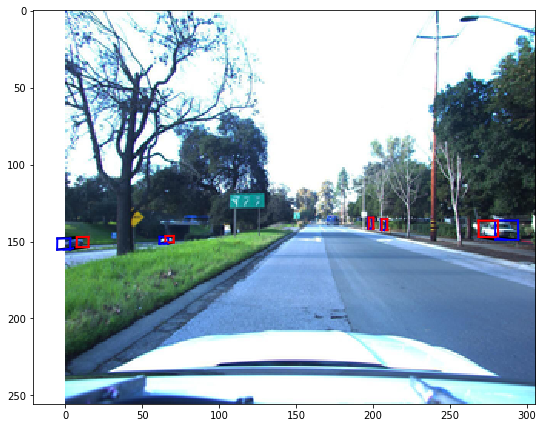

In [119]:
fig, ax = plt.subplots(1, 1, figsize=(9, 16))
ax.imshow(image)
corners = view_points(boxes[124][0].corners(), x, normalize=True)[:2, :]
corners1 = view_points(boxes[124][1].corners(), x, normalize=True)[:2, :]
#print(corners)
# Draw front (first 4 corners) and rear (last 4 corners) rectangles(3d)/lines(2d)
np_corners=corners.T[:4]
np_corners1=corners1.T[:4]

boxes[124][0].render(ax, view=x, normalize=True)
boxes[124][1].render(ax, view=x, normalize=True)
boxes[124][2].render(ax, view=x, normalize=True)
boxes[124][3].render(ax, view=x, normalize=True)
boxes[124][4].render(ax, view=x, normalize=True)

rect1 = patches.Rectangle((np_corners1[1][0], np_corners1[1][1]), np_corners1[0][0]-np_corners1[1][0], -np_corners1[1][1]+np_corners1[2][1],linewidth=1,edgecolor="r")
rect2 = patches.Rectangle((np_corners[1][0], np_corners[1][1]), np_corners[0][0]-np_corners[1][0], -np_corners[1][1]+np_corners[2][1],linewidth=1,edgecolor="r")
# Add the patch to the Axes
# ax.add_patch(rect2)
# ax.add_patch(rect1)
box_corn=[]
for box in boxes:
    corner_img_list=[]
    for i in range(len(box)):
        corners = view_points(box[i].corners(), x, normalize=True)[:2, :]
        corners_norm=[np_corners[1][0], np_corners[1][1], np_corners[0][0], np_corners[2][1]]
        corner_img_list.append(corners_norm)
    box_corn.append(np.asarray(corner_img_list))
box_corn=np.asarray(box_corn)
print("here")
print(box_corn.shape)
#for i in range(len(anchors)):
rect= patches.Rectangle((5, 9), 62, 65,linewidth=1,edgecolor="r")
# ax.add_patch(rect)

In [122]:
x=[camera_intrinsic[0]/4, camera_intrinsic[1]/4, camera_intrinsic[2]]
x=np.asarray(x)
gt_boxes_corners=[]
print(x)
for i in range(len(boxes)):    
    corner_img_list=[]
    for j in range(len(boxes[i])):
        corners = view_points(boxes[i][j].corners(), view=x, normalize=True)[:2, :]
        np_corners=corners.T[:4]
        corners_norm=[np_corners[1][0], np_corners[1][1], np_corners[0][0], np_corners[2][1]]
        corner_img_list.append(corners_norm)
    gt_boxes_corners.append(np.asarray(corner_img_list))
print(np.asarray(gt_boxes_corners[124]).shape) #125, num box in scene, 4

[[220.359692     0.         156.14924745]
 [  0.         220.359692   131.52045758]
 [  0.           0.           1.        ]]
(5, 4)


Same done above for bev

In [68]:
# from lyft_dataset_sdk.utils.geometry_utils import BoxVisibility
# fig, ax2 = plt.subplots(1, 1, figsize=(9, 16))
# bev1 = bev_helper.normalize_voxel_intensities(bev)
# bev = bev_helper.normalize_voxel_intensities(bev)
# bev2=bev
# ax2.imshow(bev1)
# sample_lidar_token = sample["data"]["LIDAR_TOP"]
# print(sample_lidar_token)
# _, boxes, _ = dataset.get_sample_data(sample_lidar_token, box_vis_level=BoxVisibility.ANY, flat_vehicle_coordinates=True)
# ego_p=dataset.get("ego_pose", lidar_data["ego_pose_token"])
# bev_helper.move_boxes_to_car_space(bevboxes, ego_pose)
# bev_helper.scale_boxes(bevboxes, 0.8)
# corners=bev_helper.draw_boxes(bev, voxel_size, boxes, classes, z_offset=z_offset)
# fig, ax3 = plt.subplots(1, 1, figsize=(9, 16))
# ax3.imshow(bev)

In [69]:
# corners_voxel_list=[]
# for box in boxes:   
#     corners = box.bottom_corners()
#     corners_voxel = bev_helper.car_to_voxel_coords(corners, [336,336,3], voxel_size, z_offset).transpose(1,0)
#     corners_voxel = corners_voxel[:,:2] # Drop z coord
#     corners_voxel_list.append(corners_voxel)
#     cv2.drawContours(bev, np.int0([corners_voxel]), 0, -1)
# plt.imshow(bev)
# print(corners_voxel_list)

In [70]:
# from lyft_dataset_sdk.utils.geometry_utils import BoxVisibility, box_in_image, view_points
# def visualize_lidar_of_sample(sample_token, axes_limit=80):
#     sample = level5data.get("sample", sample_token)
#     sample_lidar_token = sample["data"]["LIDAR_TOP"]
#     level5data.render_sample_data(sample_lidar_token, axes_limit=axes_limit)
# #visualize_lidar_of_sample(sample_name)
# my_last_sample_token = my_scene["last_sample_token"]
# sample = level5data.get("sample", my_last_sample_token)
# #sample = level5data.get("sample", sample_name)
# sample_lidar_token = sample["data"]["LIDAR_TOP"]
# print(sample_lidar_token)
# _, boxes, _ = dataset.get_sample_data(sample_lidar_token, box_vis_level=BoxVisibility.ANY, flat_vehicle_coordinates=True)
# print(len(boxes))
# sd_record = dataset.get("sample_data", sample_lidar_token)
# # Get aggregated point cloud in lidar frame.
# sample_rec = dataset.get("sample", sd_record["sample_token"])
# chan = sd_record["channel"]
# ref_chan = "LIDAR_TOP"
# pc, times = LidarPointCloud.from_file_multisweep(
#     dataset, sample_rec, chan, ref_chan, num_sweeps=1
# )

# # Compute transformation matrices for lidar point cloud
# cs_record = dataset.get("calibrated_sensor", sd_record["calibrated_sensor_token"])
# pose_record = dataset.get("ego_pose", sd_record["ego_pose_token"])
# vehicle_from_sensor = np.eye(4)
# vehicle_from_sensor[:3, :3] = Quaternion(cs_record["rotation"]).rotation_matrix
# vehicle_from_sensor[:3, 3] = cs_record["translation"]

# ego_yaw = Quaternion(pose_record["rotation"]).yaw_pitch_roll[0]
# rot_vehicle_flat_from_vehicle = np.dot(
#     Quaternion(scalar=np.cos(ego_yaw / 2), vector=[0, 0, np.sin(ego_yaw / 2)]).rotation_matrix,
#     Quaternion(pose_record["rotation"]).inverse.rotation_matrix,
# )

# vehicle_flat_from_vehicle = np.eye(4)
# vehicle_flat_from_vehicle[:3, :3] = rot_vehicle_flat_from_vehicle

# # Init axes.
# _, ax = plt.subplots(1, 1, figsize=(9, 9))


# # Show point cloud.
# points = view_points(
#     pc.points[:3, :], np.dot(vehicle_flat_from_vehicle, vehicle_from_sensor), normalize=False
# )

# dists = np.sqrt(np.sum(pc.points[:2, :] ** 2, axis=0))
# colors = np.minimum(1, dists / 40 / np.sqrt(2))
# ax.scatter(points[0, :], points[1, :], c=colors, s=0.2)

# # Show ego vehicle.
# ax.plot(0, 0, "x", color="red")

# # Show boxes.
# for box in boxes:
#     box.render(ax, view=np.eye(4), colors=("c", "c", "c"))

# # Limit visible range.
# ax.set_xlim(-70, 70)
# ax.set_ylim(-70, 70)
# ax.axis("off")
# ax.set_title(sd_record["channel"])
# ax.set_aspect("equal")

compute rpn

In [123]:
with tf.device('/CPU:0'):
    #now build the rpn and get proposals from the anchors
    k=6 #anchor number for each point
    feature_map_tile = tf.keras.layers.Input(shape=(3,3,512))
    convolution_3x3 = tf.keras.layers.Conv2D(
        filters=512,
        kernel_size=(3,3),
        strides=(3,3),
        padding='same',
        name="3x3"
    )(feature_map_tile)

    output_deltas = tf.keras.layers.Conv2D(
        filters= 4 * k,
        kernel_size=(1, 1),
        activation="linear",
        kernel_initializer="uniform",
        name="deltas1"
    )(convolution_3x3)

    output_scores = tf.keras.layers.Conv2D(
        filters=1 * k,
        kernel_size=(1, 1),
        activation="sigmoid",
        kernel_initializer="uniform",
        name="scores1"
    )(convolution_3x3)

with tf.device('/CPU:0'):
    rpn_model = tf.keras.Model(inputs=[feature_map_tile], outputs=[output_scores, output_deltas])
    #rpn_model.summary()
    rpn_model.compile(optimizer='adam', loss={'scores1':rpn_helper.loss_cls, 'deltas1':rpn_helper.smoothL1})

img_feat=np.asarray(img_features)
#img_feat=tf.convert_to_tensor(x[0])
#print(img_feat.shape)
# print(img_feat.shape)
# res=rpn_model.predict(img_feat)

In [ ]:
img_feat[124].shape
anchors

In [129]:
import numpy.random as npr
import rpn_helper

batch_tiles_list=[]
batch_label_targets_list=[]
batch_bbox_targets_list=[]
print(img_feat[45].shape)
print(gt_boxes_corners.shape)
for i in range(len(gt_boxes_corners)):
    gt_boxes=np.asarray(gt_boxes_corners[i])
    overlaps = rpn_helper.bbox_overlaps(anchors, gt_boxes)
    #print(overlaps)
    # find the gt box with biggest overlap to each anchors,
    # and the overlap ratio. result (len(anchors),)
    argmax_overlaps = overlaps.argmax(axis=1)
    max_overlaps = overlaps[np.arange(len(inds_inside)), argmax_overlaps]
    # find the anchor with biggest overlap to each gt boxes,
    # and the overlap ratio. result (len(gt_boxes),)
    gt_argmax_overlaps = overlaps.argmax(axis=0)
    #print(gt_argmax_overlaps)
    gt_max_overlaps = overlaps[gt_argmax_overlaps,
                                np.arange(overlaps.shape[1])]

    gt_argmax_overlaps = np.where(overlaps == gt_max_overlaps)[0]
    max_overlaps=max_overlaps*10
    labels = np.empty((len(inds_inside), ), dtype=np.float32)
    labels.fill(-1)
    labels[gt_argmax_overlaps] = 1

    labels[max_overlaps >= .7] = 1
    # set negative labels
    labels[max_overlaps <= .1] = 0
    print(labels.shape)
    # subsample positive labels if we have too many
    #     num_fg = int(RPN_FG_FRACTION * RPN_BATCHSIZE)
    fg_inds = np.where(labels == 1)[0]
    num_bg = int(len(fg_inds) * 2)
    bg_inds = np.where(labels == 0)[0]
    if len(bg_inds) > num_bg:
        disable_inds = npr.choice(
            bg_inds, size=(len(bg_inds) - num_bg), replace=False)
        labels[disable_inds] = -1
    #
    batch_inds=inds_inside[labels!=-1]
    batch_inds=(batch_inds / k).astype(np.int)
    full_labels = rpn_helper.unmap(labels, total_anchors, inds_inside, fill=-1)
    batch_label_targets=full_labels.reshape(-1,1,1,1*k)[batch_inds]
    bbox_targets = np.zeros((len(inds_inside), 4), dtype=np.float32)
    bbox_targets = rpn_helper.bbox_transform(anchors, gt_boxes[argmax_overlaps, :])
    pos_anchors=all_anchors[inds_inside[labels==1]]
    bbox_targets = rpn_helper.bbox_transform(pos_anchors, gt_boxes[argmax_overlaps, :][labels==1])
    bbox_targets = rpn_helper.unmap(bbox_targets, total_anchors, inds_inside[labels==1], fill=0)
    batch_bbox_targets = rpn_helper.bbox_targets.reshape(-1,1,1,4*k)[batch_inds]
    feature_map=tf.expand_dims(img_feat[i], axis=0)
    padded_fcmap=np.pad(feature_map,((0,0),(1,1),(1,1),(0,0)),mode='constant')
    padded_fcmap=np.squeeze(padded_fcmap)
    print(batch_bbox_targets.shape, batch_label_targets.shape)
    batch_tiles=[]
    for ind in batch_inds:
        x = ind % f_map_img_w
        y = int(ind/f_map_img_w)
        fc_3x3=padded_fcmap[y:y+3,x:x+3,:]
        batch_tiles.append(fc_3x3)
    print(i,tf.convert_to_tensor(batch_tiles).shape)
    batch_tiles_list.append(tf.convert_to_tensor(batch_tiles))
    batch_label_targets_list.append(tf.convert_to_tensor(batch_label_targets))
    batch_bbox_targets_list.append(tf.convert_to_tensor(batch_bbox_targets))
# batch_tiles_list=np.asarray(batch_tiles_list)
# batch_label_targets_list=np.asarray(batch_label_targets_list)
# batch_bbox_targets_list=np.asarray(batch_bbox_targets_list)

NameError: name 'np' is not defined

In [74]:
#batch_label_targets_list

In [74]:
print(len(batch_tiles_list[0]))
print(batch_label_targets_list[0].shape ,batch_bbox_targets_list[0].shape)

33
(33, 1, 1, 6) (33, 1, 1, 24)


In [89]:
def input_generator():
    for i in range(len(batch_tiles_list)):
        a=batch_tiles_list[i]
        b=batch_label_targets_list[i]
        c=batch_bbox_targets_list[i]    
        yield a, [b,c]

with tf.device('/CPU:0'):
    #rpn_model.compile(optimizer='adam', loss={'deltas1':'mse', 'scores1':'binary_crossentropy'})
    #rpn_model.summary()
    rpn_model.fit(input_generator(), epochs=3)
    stuff=rpn_model.predict(batch_tiles_list[0:30])
    print(stuff[1])

Epoch 1/3
     44/Unknown - 0s 0s/step - loss: 10.6038 - scores1_loss: 4.7673 - deltas1_loss: 5.83 - 0s 40ms/step - loss: 17.0015 - scores1_loss: 2.7618 - deltas1_loss: 14.239 - 0s 52ms/step - loss: 18.0854 - scores1_loss: 2.4255 - deltas1_loss: 15.659 - 0s 58ms/step - loss: 16.3350 - scores1_loss: 2.2092 - deltas1_loss: 14.125 - 0s 62ms/step - loss: 14.9920 - scores1_loss: 1.8184 - deltas1_loss: 13.173 - 0s 64ms/step - loss: 15.6585 - scores1_loss: 1.8101 - deltas1_loss: 13.848 - 0s 66ms/step - loss: 15.7554 - scores1_loss: 1.7164 - deltas1_loss: 14.039 - 1s 69ms/step - loss: 15.4780 - scores1_loss: 1.6268 - deltas1_loss: 13.851 - 1s 71ms/step - loss: 14.9204 - scores1_loss: 1.5152 - deltas1_loss: 13.405 - 1s 74ms/step - loss: 14.5317 - scores1_loss: 1.5780 - deltas1_loss: 12.953 - 1s 74ms/step - loss: 14.2413 - scores1_loss: 1.5401 - deltas1_loss: 12.701 - 1s 75ms/step - loss: 14.0133 - scores1_loss: 1.4210 - deltas1_loss: 12.592 - 1s 75ms/step - loss: 13.7220 - scores1_loss: 1.3117 

InvalidArgumentError:  ValueError: `generator` yielded an element of shape (0,) where an element of shape (None, None, None, None) was expected.
Traceback (most recent call last):

  File "C:\Users\Utente1\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\script_ops.py", line 244, in __call__
    ret = func(*args)

  File "C:\Users\Utente1\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\autograph\impl\api.py", line 302, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\Utente1\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 863, in generator_py_func
    "of shape %s was expected." % (ret_array.shape, expected_shape))

ValueError: `generator` yielded an element of shape (0,) where an element of shape (None, None, None, None) was expected.


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_10697]

Function call stack:
train_function


In [76]:
print(np.asarray(batch_tiles).shape)
print(-1.81e+01==-18.1)


(3, 3, 3, 512)
True
